### Урок 5. Случайный лес

#### __1__. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках
(по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import numpy as np
from sklearn import datasets
import random
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
# сгенерируем данные, представляющие собой 100 объектов с 2-я признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [3]:
classification_data[0:10]

array([[-1.27616996, -1.15229747],
       [ 0.75362536, -0.89523588],
       [ 0.23440873, -1.23792282],
       [ 0.95210618, -0.24334078],
       [-1.82938967, -0.74000927],
       [ 1.27392667, -0.87420414],
       [ 0.2983303 , -1.20310229],
       [ 0.30003015, -1.43463906],
       [ 1.30650827, -1.89704851],
       [ 0.88766803, -3.69984116]])

In [4]:
classification_labels

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

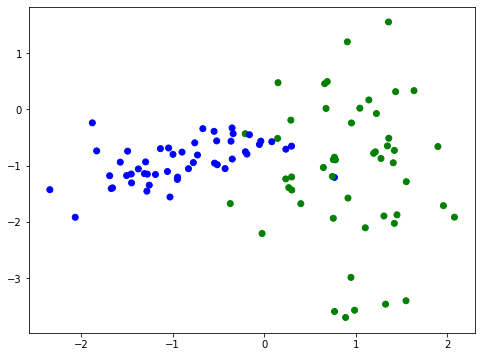

In [5]:
# Визуализируем сгенерированные данные
colors = ListedColormap(['green', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(8,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [6]:
random.seed(42)
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    # Задание 
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [7]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)  # перемешаем список индексов
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [8]:
# Реализуем класс узла
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t          # значение порога
        self.true_branch = true_branch    # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [9]:
# Класс терминального узла (листа)
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [10]:
# Расчет критерия Джини
def gini(labels):
    classes = {}    #  подсчет количества объектов разных классов
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [11]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [12]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [15]:
# Функция формирования случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [16]:
# Функция классификации отдельного объекта
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# предсказание голосованием деревьев
def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [19]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                   classification_labels, test_size = 0.3, random_state = 1)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
def random_forest_pred(n_trees):
    global train_data, train_labels
    
    my_forest = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers  = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy  = accuracy_metric(test_labels, test_answers)
    
    return train_accuracy, test_accuracy, my_forest

In [22]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [23]:
def rf_plt(train_accuracy, test_accuracy, forest):
    global colors, light_colors
    global train_data, train_labels, test_data, test_labels    
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    light_colors = ListedColormap(['lightgreen', 'lightblue'])
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

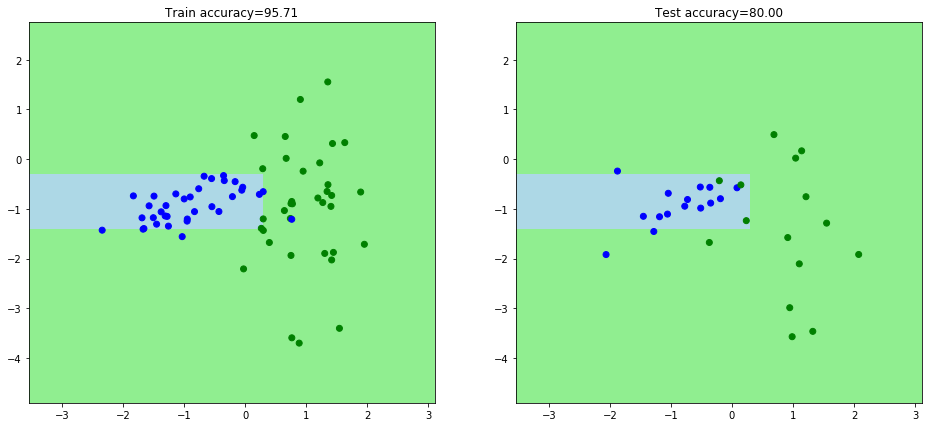

In [24]:
n_trees = 1
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

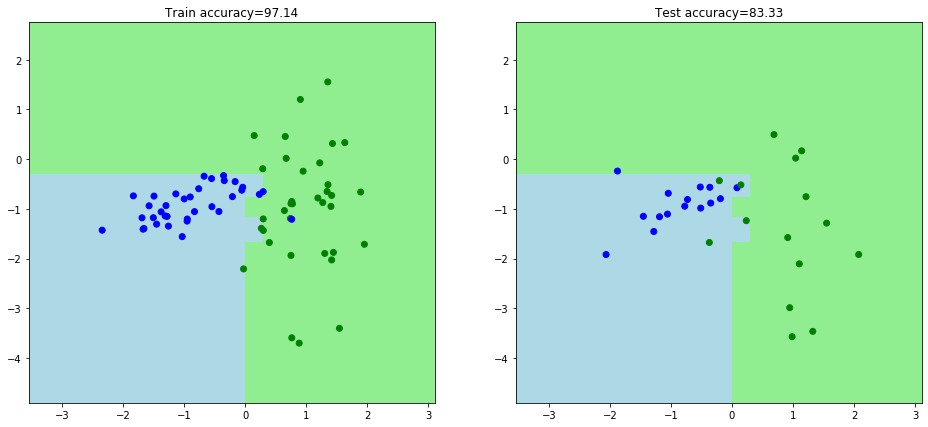

In [25]:
n_trees = 3
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

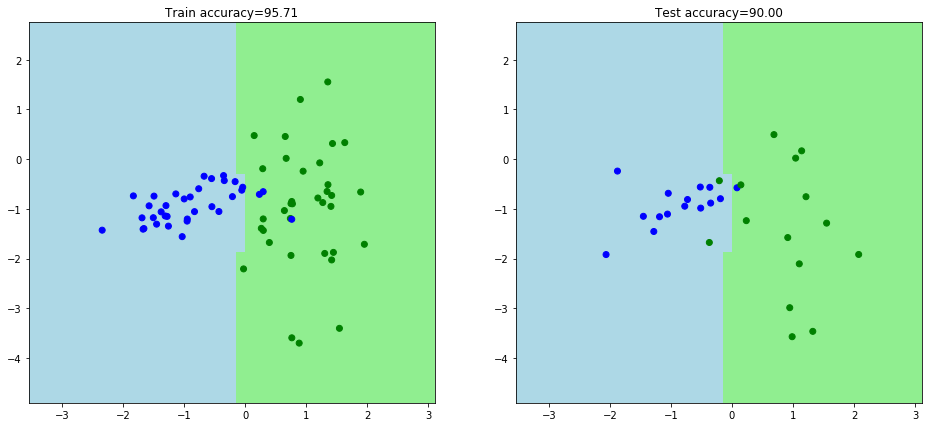

In [26]:
n_trees = 5
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

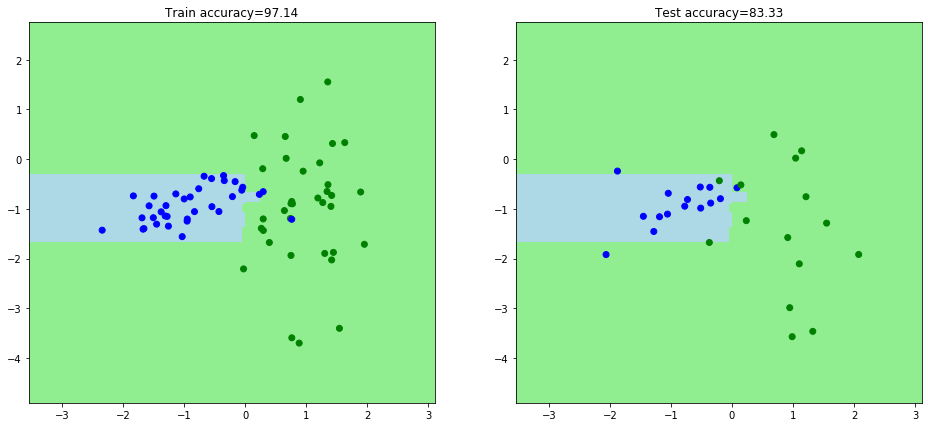

In [27]:
n_trees = 7
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

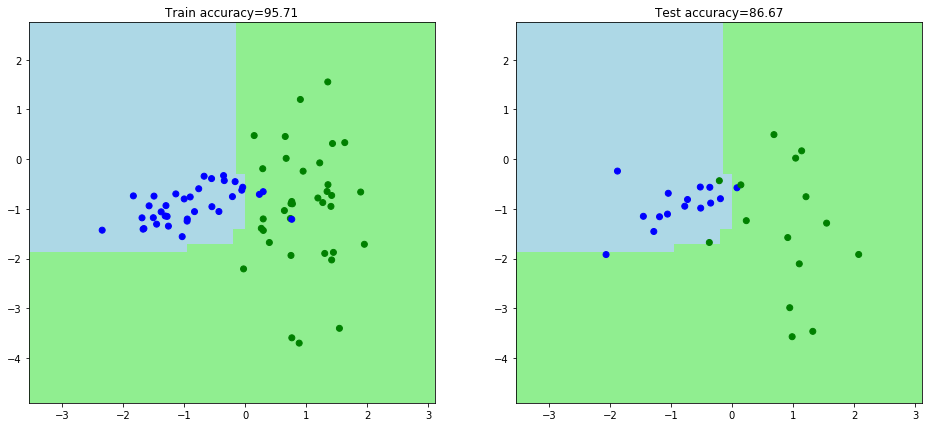

In [28]:
n_trees = 10
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

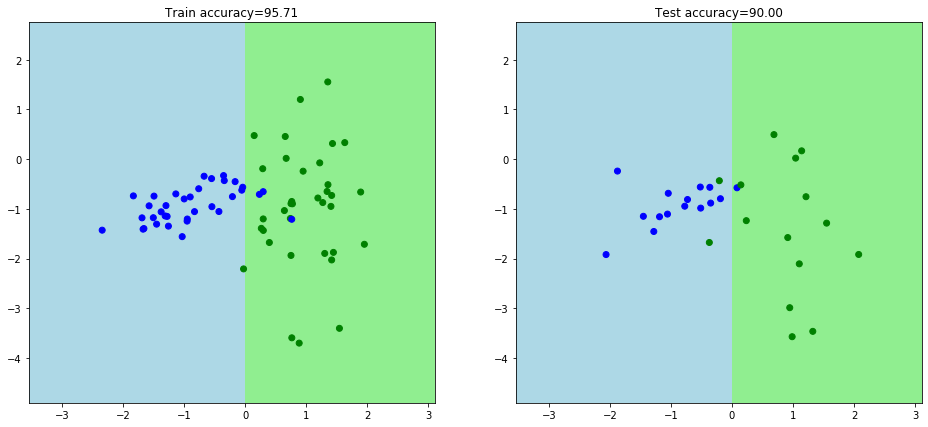

In [29]:
n_trees = 50
train_acc, test_acc, forest = random_forest_pred(n_trees)
rf_plt(train_acc, test_acc, forest)

#### __2__. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

С ростом количества деревьев усложняется форма гиперплоскости. Переобучение не наблюдается.

In [30]:
def compare(train_data, train_labels, test_data, test_labels, n_trees):
    
    rf = random_forest(data=train_data, labels=train_labels, n_trees=n_trees)
    train_answers = tree_vote(forest=rf, data=train_data)
    test_answers  = tree_vote(forest=rf, data=test_data)
    train_accuracy = accuracy_metric(actual=train_labels, predicted=train_answers)
    test_accuracy  = accuracy_metric(actual=test_labels, predicted=test_answers)
            
    return rf, train_accuracy, test_accuracy

In [37]:
tree_range = [1, 3, 5, 7, 10, 50]
train_acc, test_acc = [], []
for n in tree_range:
    np.random.seed(42)
    rf, train_accuracy, test_accuracy = compare(train_data, train_labels, test_data, test_labels, n_trees=n)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

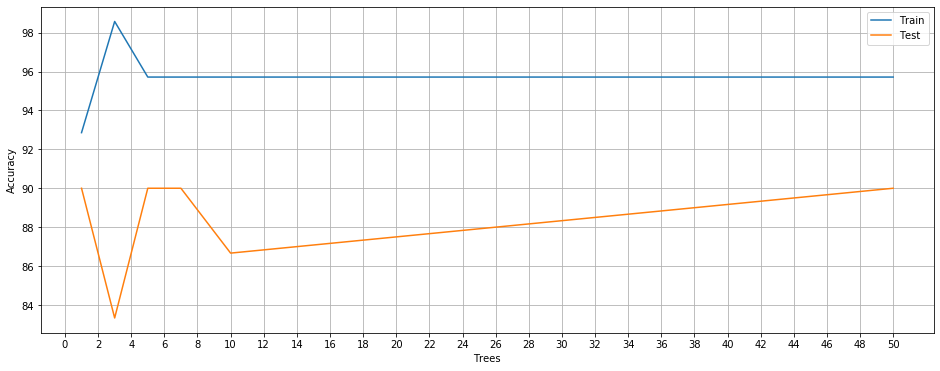

In [38]:
plt.figure(figsize=(16,6))
plt.xlabel("Trees")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 51, 2))
plt.plot(tree_range, train_acc, label='Train')
plt.plot(tree_range, test_acc,  label='Test')
plt.legend()
plt.grid()
plt.show()

#### В данном примере, при числе деревьев = [5, 7] - максимальная метрика качества.

#### __3__. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag

In [68]:
random.seed(42)
def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        indicies = []
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indicies.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

        oob_id = [id for id in range(n_samples) if id not in set(indicies)]
        oob_dat = data[oob_id]
        oob_lab = labels[oob_id]
        oob.append((oob_dat, oob_lab))
   
    return bootstrap, oob

In [69]:
def calc_oob_acc(oob, tree):
    oob_answers = predict(oob[0], tree)
    oob_acc = accuracy_metric(oob[1], oob_answers)
    return oob_acc

In [79]:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, oob = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    oob_acc = 0
    for i in range(n_trees):
        oob_acc += calc_oob_acc(oob[i], forest[i])
    oob_acc = oob_acc / n_trees
    
    return forest, oob_acc

In [80]:
n_trees = 3
my_forest, oob_score = random_forest_oob(train_data, train_labels, n_trees)
oob_score

81.60839160839161

In [81]:
n_trees = 5
my_forest, oob_score = random_forest_oob(train_data, train_labels, n_trees)
oob_score

92.52178855627132

#### __4__. Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [82]:
# Расчет критерия Шеннона
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p)
        
    return impurity